In [ ]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import phik


sns.set_palette('Set2')

In [ ]:
load_dotenv(".env")
DB_USER=os.getenv("DB_USER")
DB_PASS=os.getenv("DB_PASS")
DB_HOST=os.getenv("DB_HOST")
DB_PORT=os.getenv("DB_PORT")
DB_NAME=os.getenv("DB_NAME")

engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

In [ ]:
"""Загрузка в postgresql"""

#df = pd.read_excel("e_commerce_dataset.xlsx",sheet_name='E Comm')
#df.to_sql(name='ecommerce',con=engine,if_exists='replace',index=False)
#df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [45]:
df = pd.read_sql('select * from ecommerce',engine)

In [ ]:
display(f'Размер: {df.shape}')
display(f'Дубликаты: {df.duplicated().sum()}')
display('Пропуски:')
df.isna().sum().reset_index(name='sum').query('sum>0')

'Размер: (5630, 20)'

'Дубликаты: 0'

'Пропуски:'

,index,sum
2,Tenure,264
5,WarehouseToHome,251
8,HourSpendOnApp,255
15,OrderAmountHikeFromlastYear,265
16,CouponUsed,256
17,OrderCount,258
18,DaySinceLastOrder,307


Есть пропуски в столбцах Tenure, WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder.


Пропуски нужно будет заполнить. Но позже

In [73]:
df.dtypes

Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [60]:
df = df.set_index('CustomerID')

In [87]:
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'], dtype='object')

In [86]:
display('Распределение таргета')
df['Churn'].value_counts(normalize=True)

'Распределение таргета'

Churn
0    0.8316
1    0.1684
Name: proportion, dtype: float64

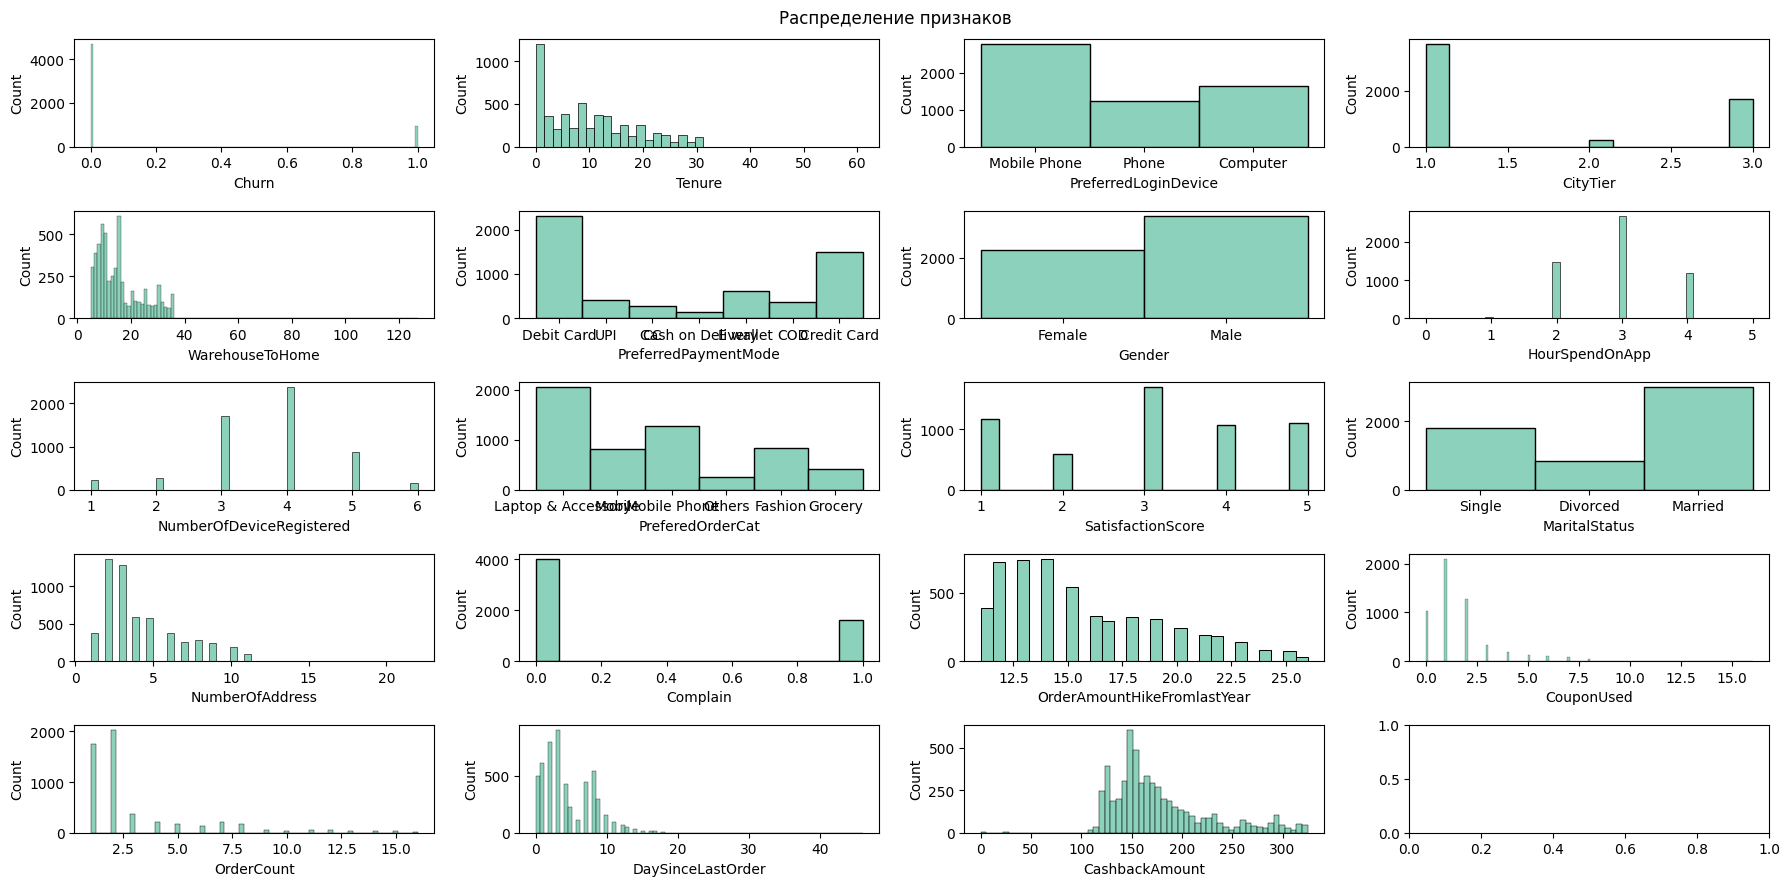

In [101]:
fig,axes = plt.subplots(5,4,figsize=(18,9))
plt.suptitle('Распределение признаков')
axes = axes.flatten()
for i,col in enumerate(df.columns):
    sns.histplot(data=df,x=col,ax=axes[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(18,9))
sns.histplot(data=df,x='WarehouseToHome',color='orange')
plt.axvline(df['WarehouseToHome'].median(),color='black',linestyle='--',label='median')
plt.axvline(df['WarehouseToHome'].mean(),color='blue',linestyle='--',label='mean')
plt.legend()

In [116]:
df['WarehouseToHome'].quantile(0.99)


np.float64(35.0)

In [ ]:
plt.figure(figsize=(18,9))
sns.histplot(data=df,x='PreferedOrderCat',color='orange')

plt.legend()

1. Churn. Есть дисбаланс таргета. Клиентов, которые отстались, больше. 0 - это те, кто не ушли. 1 - кто, ушли.
2. Tenure. Большинство клиентов новые. Но есть, которые уже ранее пользовались услугами
3. PreferredLoginDevice. Большниство заказывают через телефон.
4. CityTier. 1 и 3 преобладают
5. WarehouseToHome. Время доставки, предположу, что в минутах. 99 % времени доставки меньше 35 минут. Есть огромный выброс, который больше 120 минут.
6. PrefferdPaymentMode. Способ оплаты. Большинство платят через карты, дебетувую или кредитную.
7. Male. Больше мужчин, чем женщин.
8. HourSpendOnApp. Большинство проводят около 3 часов в приложении.
9. NumberOfDeviceRegistred. Количество устройств у пользователя. У большинства 4.
10. PreferedOrderCat. Большинство покупают ноутбуки и перефирую для них.
11. SatisfactionScore. Оценка удовлетворенности клиента. Большинство - 3. Нейтрально или равнодушно.
12. MartialStatus. Большинство в браке.
13. NumberofAddress. Кол - во адресов у пользователя.
14. Complain. Флаг. Была ли жалоба или нет.0 - не было жалобы, 1 - была жалоба.
15. OrderAmountHikeFromlastYear. На сколько выросло кол-во заказов. У большинства на 13%
16. CouponUsed. Количество купонов использовано. Большинство использовало либо 0, либо 1
17. OrderCount. Кол - во заказов. В большинстве  - 1 покупка или 0. Но есть и постоянные покупатели.
18. DaySinceLastOrder. Дней с последнего заказа. Примерно 5 дней. Есть выброс - более 40 дне
19. CashBackAmount. Кешбек за последний месяц. У большинства 150.




In [174]:
X_phik = df.phik_matrix()

interval columns not set, guessing: ['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


<Axes: >

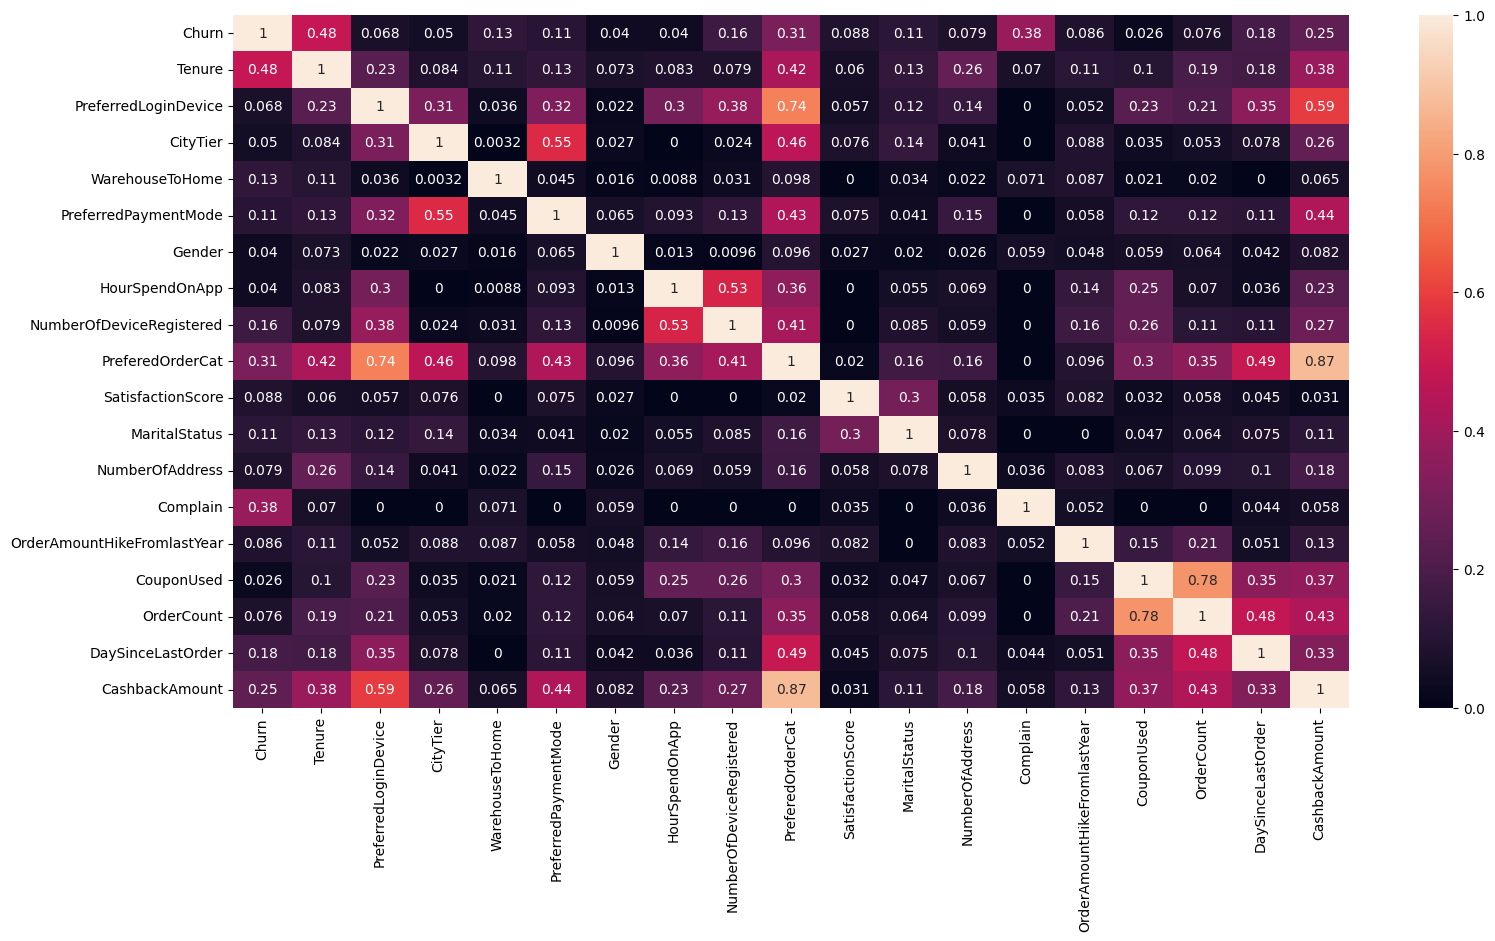

In [175]:
plt.figure(figsize=(18,9))
sns.heatmap(X_phik,annot=True)

1. Видими, что некоторые признаким кореллируют между собой. Например количество заказов и количество использованных купонов. Это логично, значит, что клиенты пользуются купонами. Количество кешбека и колиество времени в организации. Логично, что у лояльных клиентов больше кешбека. 
2. Признаки кореллируют с таргетом, Чем больше времени в организации клиент, тем меньше он подвержден "Оттоку". Если есть жалобы, то клиент больше подвержен оттоку.

In [247]:
## Обработка пропусков и выбросов
df = df[df['Tenure']<=30]
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df = df[df['WarehouseToHome']<=40]
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())

df['HourSpendOnApp'] = df['HourSpendOnApp'].replace({1.0:3,0.0:3.0,5.0:3.0})
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].mode()[0])

df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())

df = df[df['CouponUsed']<=8]
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].mode()[0])

df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].mode()[0])

df = df[df['DaySinceLastOrder']<=20]

df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].mode()[0])





In [248]:
df.isna().sum().reset_index(name='sum').query('sum>0')

,index,sum


<Axes: xlabel='DaySinceLastOrder', ylabel='Count'>

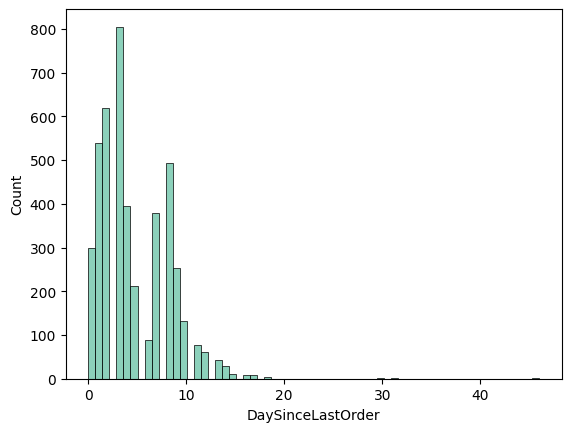

In [246]:
sns.histplot(data=df,x='DaySinceLastOrder')

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4461 entries, 50001 to 55630
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        4461 non-null   int64  
 1   Tenure                       4461 non-null   float64
 2   PreferredLoginDevice         4461 non-null   object 
 3   CityTier                     4461 non-null   int64  
 4   WarehouseToHome              4461 non-null   float64
 5   PreferredPaymentMode         4461 non-null   object 
 6   Gender                       4461 non-null   object 
 7   HourSpendOnApp               4461 non-null   float64
 8   NumberOfDeviceRegistered     4461 non-null   int64  
 9   PreferedOrderCat             4461 non-null   object 
 10  SatisfactionScore            4461 non-null   int64  
 11  MaritalStatus                4461 non-null   object 
 12  NumberOfAddress              4461 non-null   int64  
 13  Complain          

In [252]:
pd.read_sql('select * from ecommerce',con=engine)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


In [ ]:
#df.reset_index().to_sql(name='ecommerce_cleaned',con=engine,if_exists='replace',index=False)

461

In [258]:
pd.read_sql('select * from ecommerce_cleaned',engine)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
2,50005,1,0.0,Phone,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
3,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19
4,50009,1,13.0,Phone,3,9.0,E wallet,Male,3.0,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,126.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,55625,0,1.0,Mobile Phone,3,12.0,UPI,Female,2.0,5,Mobile Phone,3,Single,2,0,19.0,2.0,2.0,1.0,154.66
4457,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
4458,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
4459,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


Добавлю новый признак - количество кешбека с заказа


In [259]:
#feature engineering

df['cashbk_per_order'] = df['CashbackAmount'] / df['OrderCount']

In [ ]:
#df.reset_index().to_sql(name='ecommerce_features',con=engine,if_exists='replace',index=False)

461

In [262]:
pd.read_sql('select * from ecommerce_features',engine)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,cashbk_per_order
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,159.9300
1,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07,134.0700
2,50005,1,0.0,Phone,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60,129.6000
3,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19,23.1983
4,50009,1,13.0,Phone,3,9.0,E wallet,Male,3.0,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,126.83,126.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,55625,0,1.0,Mobile Phone,3,12.0,UPI,Female,2.0,5,Mobile Phone,3,Single,2,0,19.0,2.0,2.0,1.0,154.66,77.3300
4457,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71,75.3550
4458,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42,93.2100
4459,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90,89.4500
